## Data Dictionary

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 0.0 Imports 

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

In [4]:
# Set the style
sns.set_style('darkgrid')

# Set to display an unlimited number of columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None


### 0.1 Helper Functions

In [5]:

def camel_to_snake(s):
    # Function that converts camel style to snake style
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [6]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [7]:
# Function that put the information of values inside the graphic
def label_graph(ax, fmt):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), fmt), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

In [8]:
# Function that customize the plot
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

In [9]:
 def find_outliers(df, col_name):
    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(df[col_name], 0.25)
    Q3 = np.quantile(df[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Outliers limit for {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")
    
    return low_outliers, high_outliers

In [296]:
# Function that measures the association between two categorical variables
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

### 0.2 Loading Data

In [10]:
# Read CSV
df0 = pd.read_csv('../data/historical_data.csv',low_memory=True)

In [11]:
# Display the first 5 rows
df0.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.0 Data Description

This section give to you the understanding of the dataset, through the features it has.

In [12]:
df1 = df0.copy()

In [13]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### 1.1 Rename Columns

In [14]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
           'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
           'isFlaggedFraud']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

In [15]:
df1.rename(columns = {'oldbalance_org' : 'oldbalance_orig'}, inplace = True)

### 1.2 Data Dimensions

In [16]:
print("Number of examples:", df1.shape[0])
print("Number of features:", df1.shape[1])

Number of examples: 6362620
Number of features: 11


### 1.3 Data Type

In [17]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_orig     float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

### 1.4 Checking Missing Values

In [18]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_orig     0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

The dataset does not have missing values.

### 1.5 Descriptive Statistics

#### 1.5.1 Numerical Attributes

In [19]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [20]:
desc_analysis = descriptive_analysis(num_attributes)
desc_analysis

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,step,2.433972e+02,239.000,1.423320e+02,1.0,7.430000e+02,7.420000e+02,0.375177,0.329071
1,amount,1.798619e+05,74871.940,6.038582e+05,0.0,9.244552e+07,9.244552e+07,30.993949,1797.956705
2,oldbalance_orig,8.338831e+05,14208.000,2.888242e+06,0.0,5.958504e+07,5.958504e+07,5.249136,32.964879
3,newbalance_orig,8.551137e+05,0.000,2.924048e+06,0.0,4.958504e+07,4.958504e+07,5.176884,32.066985
4,oldbalance_dest,1.100702e+06,132705.665,3.399180e+06,0.0,3.560159e+08,3.560159e+08,19.921758,948.674125
5,newbalance_dest,1.224996e+06,214661.440,3.674129e+06,0.0,3.561793e+08,3.561793e+08,19.352302,862.156508
6,is_fraud,1.290820e-03,0.000,3.590479e-02,0.0,1.000000e+00,1.000000e+00,27.779538,769.702982
7,is_flagged_fraud,2.514687e-06,0.000,1.585775e-03,0.0,1.000000e+00,1.000000e+00,630.603629,397659.062500


- **step** has 743 hours of simulation;
- The variable **amount, oldbalance_orig, new_balance_orig, oldbalance_dest, new_balance_dest** are very skewd and have a lot of kurtosis, it indicates that does not follow a normal distribution;
- Median of the variables mentioned above can represent better the central tendency;
- **is_fraud** and **is_flagged_fraud** are binary variables;

#### 1.5.2 Categorical Attributes

In [21]:
cat_attributes.nunique()

type               5
name_orig    6353307
name_dest    2722362
dtype: int64

- 6.35kk of unique people started a transaction and 2.72kk of unique people received a transaction.

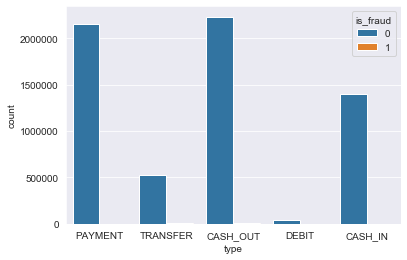

In [22]:
sns.countplot(x = 'type', hue = 'is_fraud', data = df1)

- It is impossible to analyze NOW the impact of **is_fraud** in variable **type** due to dataset imbalance;
- The most common form of transaction is **cash_out**, followed by **payment** and **cash_in**. 

## 2.0 Feature Engineering

The section of Feature Engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. This may be useful to improve the performance of machine learning algorithms and also to get experience about the business model in order to generate new insights.

In [23]:
df2 = df1.copy()

### 2.1 Hypothesis Mind Map

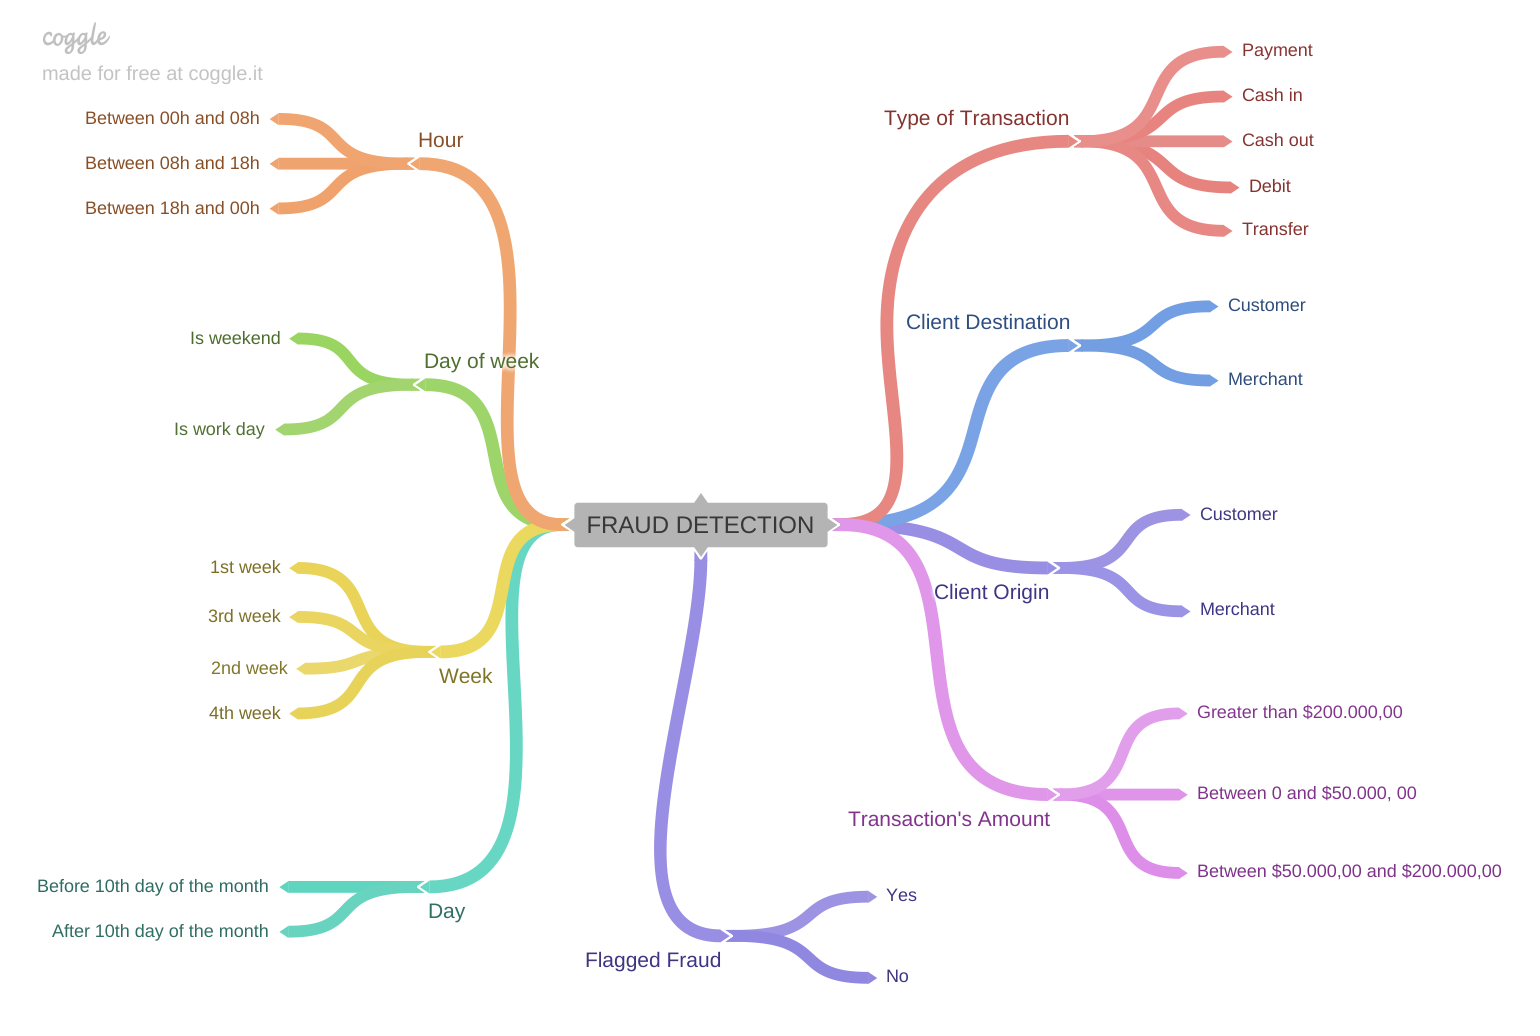

In [24]:
Image('../images/mind_map_fraud.png')

### 2.2 Hypothesis List

**H1** - Transactions classified as transfer is more likely to be fraud;

**H2** - The average amount of money of fraudulent transactions classified as transfer is the highest value.

**H3** - Customer-customer transactions tend to be more fraudulent than Customer-Merchant.

**H4** - Transactions over \\$200.000,00 are always fraudulent.

**H5** - Transactions between 0 and \\$50.000,00 are more likely to be fraud than those between \\$50.000,00 and \\$200.000,00.

**H6** - Transactions before the 10th day of the month are more likely to be fraud.

**H7** - The first week of the month are more likely to be fraud.

**H8** - Transactions during the work day are more likely to be fraud.

**H9** - Transactions after 18h are more likely to be fraud.

**H10** - When the transaction reach oldbalance_old equal zero, it is more likely to be fraud;

**H11** - When the transaction has an amount greater than oldbalance_old, it is more likely to be fraud;

Since it is a simulation of 30 days, I am going to consider it from a specific time in the beginning of the month. 

In [25]:
# Function that calculates the error after a transaction in the origin side
def error_after_transaction_orig(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old + amount - new
    elif transaction_type == 'CASH_OUT':
        return old - amount - new
    elif transaction_type == 'DEBIT':
        return old - amount - new
    elif transaction_type == 'PAYMENT':
        return old - amount - new
        
    else:
        return old - amount - new

In [26]:
# Function that calculates the error after a transaction in the destination side
# NEW and OLD balance for Merchants are always 0
def error_after_transaction_dest(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old - amount - new
    elif transaction_type == 'CASH_OUT':
        return old + amount - new
    elif transaction_type == 'DEBIT':
        return old + amount - new
    elif transaction_type == 'PAYMENT':
        return 0 
        
    else:
        return old + amount - new

In [27]:
#  Stratifying the transaction's amount 
df2['amount_group'] = df2['amount'].apply(lambda x: 0 if x < 50000 else 1 if (x >=50000) & (x < 200000) else 2)

# Since it is a simulation, I'm going to consider it started in 01/09/2015 00:00:00 and each step is one hour
df2['date'] = df2['step'].apply(lambda x:  datetime(2015, 9, 1, 00, 00, 00) + timedelta(hours=x))

# Extract day
df2['day'] = df2['date'].dt.day

# Extract day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# Extract the week
df2['week'] = df2['day'].apply(lambda x:
                                         1 if 1 <= x <= 7 else
                                         2 if 8 <= x <= 15 else
                                         3 if 16 <= x <= 23 else
                                         4)

# Extract hour
df2['hour'] = df2['date'].dt.hour

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_orig'] = df2.apply(lambda x: error_after_transaction_orig(x['type'], x['oldbalance_orig'], x['newbalance_orig'], x['amount']), axis = 1)

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_dest'] = df2.apply(lambda x: error_after_transaction_dest(x['type'], x['oldbalance_dest'], x['newbalance_dest'], x['amount']), axis = 1)

# Define if a client of origin is a Customer or a Merchant
df2['client_origin'] = df2['name_orig'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')

# Define if a client of destination is a Customer or a Merchant
df2['client_destination'] = df2['name_dest'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')


In [28]:
df2.sample()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,amount_group,date,day,day_of_week,hour,error_after_tran_orig,error_after_tran_dest,client_origin,client_destination
31956,8,CASH_OUT,224619.88,C206415921,11289.0,0.0,C941250063,17594.0,242213.88,0,0,2,2015-09-01 08:00:00,1,1,8,-213330.88,0.0,Customer,Customer


## 3.0 Data Filtering

In [29]:
df3 = df2.copy()

In [30]:
cols_to_drop = ['step', 'name_orig', 'name_dest']
df3 = df3.drop(cols_to_drop, axis = 1)

- I've dropped the **step** column due to creation of a date column;
- I've dropped **name_orig** and **name_dest** because I don't believe there are more informations than Customer and Merchant in this moment.

## 4.0 Exploratory Data Analysis (EDA)

This section is used to understand the business and the dataset. It is the most important part to report some useful insights for the managers. To analyze it, I will consider 3 analysis:

Univariate - The distribution, countplot and boxplot of each variable. It is important to remove outliers further.

Bivariate - All the hypothesis can be answered in this subsection. It can analyze the impact of each feature in the target variable;

Multivariate - Important to remove colinearity.

In [31]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Target Variable

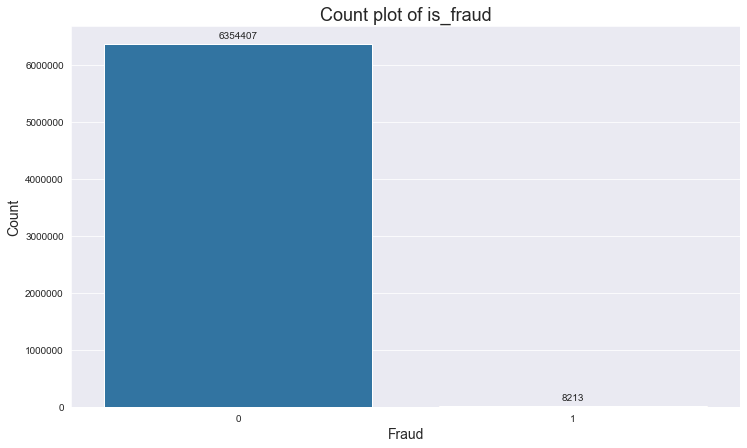

In [32]:
plt.figure(1, figsize=(12,7))
ax = sns.countplot(x = 'is_fraud', data = df4)

set_plots_features(ax, 'Count plot of is_fraud', 'Fraud', 'Count')
label_graph(ax, 'd')

It is not possible to visualize the graphic well due to the imbalance on the dataset. This problem need to be fixed in the following sections.

#### 4.1.2 Numerical Attributes

In [33]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])

In [34]:
num_attributes.shape

(6362620, 13)

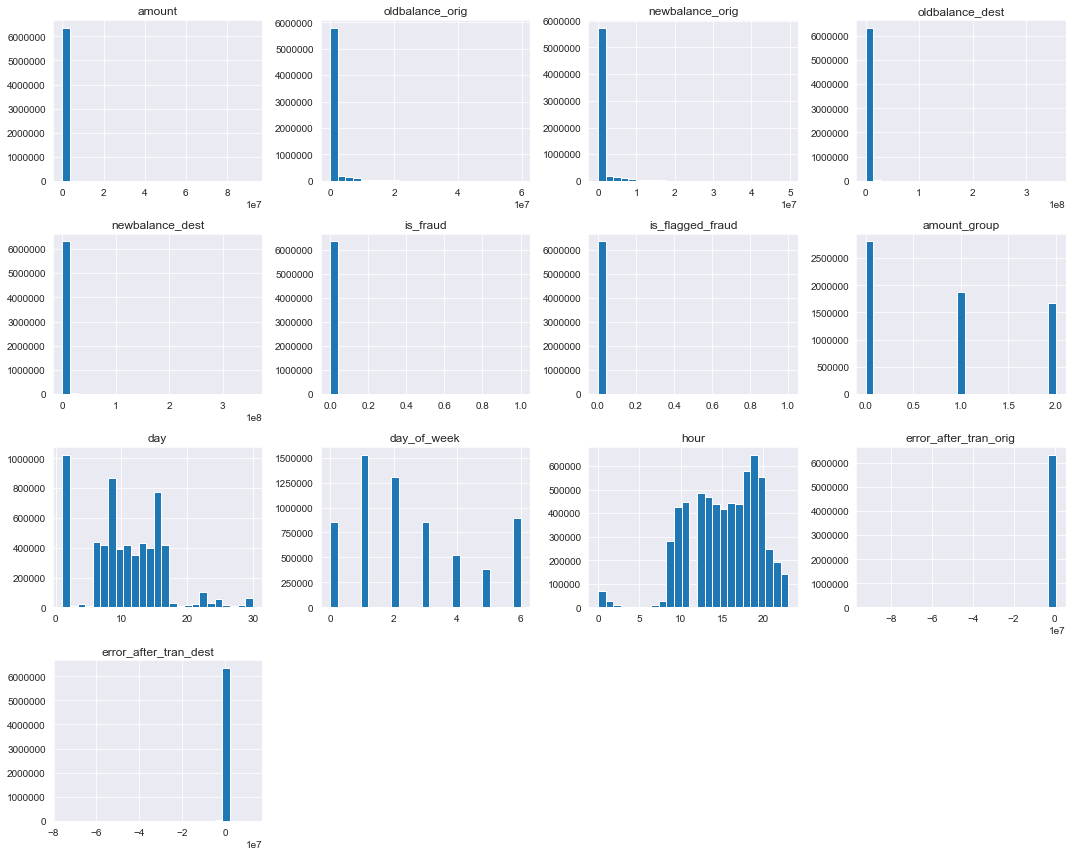

In [35]:
num_attributes.hist(bins=25, figsize=(15,12))
plt.tight_layout()

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\joaop\anaconda3\lib\site-

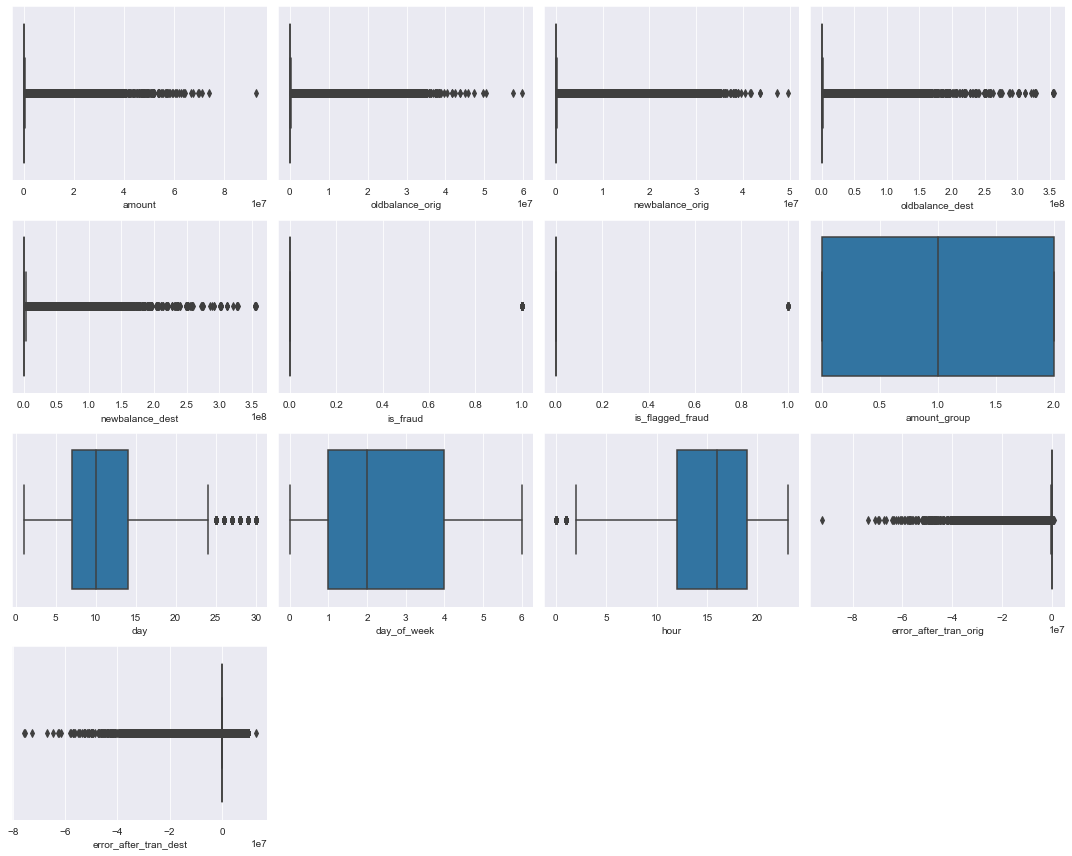

In [36]:
plt.figure(1, figsize = (15,12))
for i, col in enumerate(num_attributes.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(num_attributes[col])
    plt.xlabel(col)
    
plt.tight_layout()

- By using  histogram and boxplot, it is possible to check that the dataset contains a lot of outliers with exception of time feature. Then, I will analyze it filtering the outliers with IQR method.

Outliers limit for amount:
Q1 = 13389.57
Q3 = 208721.4775
IQR = 195331.9075
low_outliers = -279608.29125
high_outliers = 501719.33875


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C36D8EE10>]],
      dtype=object)

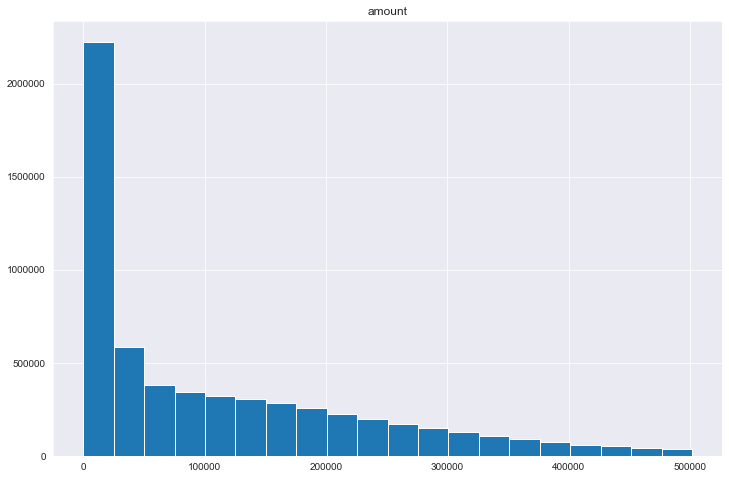

In [37]:
# Amount
low, high = find_outliers(num_attributes,  'amount')    
num_attributes[(num_attributes['amount'] > low) & (num_attributes['amount'] < high)].hist(column = 'amount', bins = 20, figsize = (12,8))

Outliers limit for oldbalance_orig:
Q1 = 0.0
Q3 = 107315.175
IQR = 107315.175
low_outliers = -160972.7625
high_outliers = 268287.9375


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C36E246D8>]],
      dtype=object)

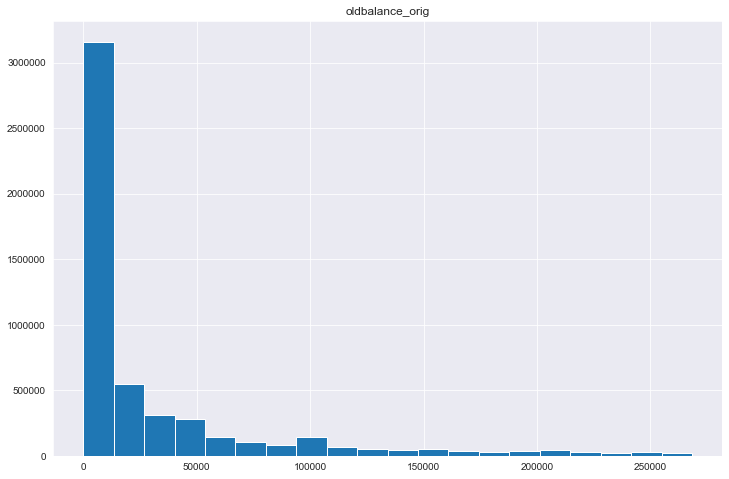

In [38]:
# Amount
low, high = find_outliers(num_attributes,  'oldbalance_orig')    
num_attributes[(num_attributes['oldbalance_orig'] > low) & (num_attributes['oldbalance_orig'] < high)].hist(column = 'oldbalance_orig', bins = 20, figsize = (12,8))

Outliers limit for newbalance_orig:
Q1 = 0.0
Q3 = 144258.41
IQR = 144258.41
low_outliers = -216387.615
high_outliers = 360646.025


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C39125E10>]],
      dtype=object)

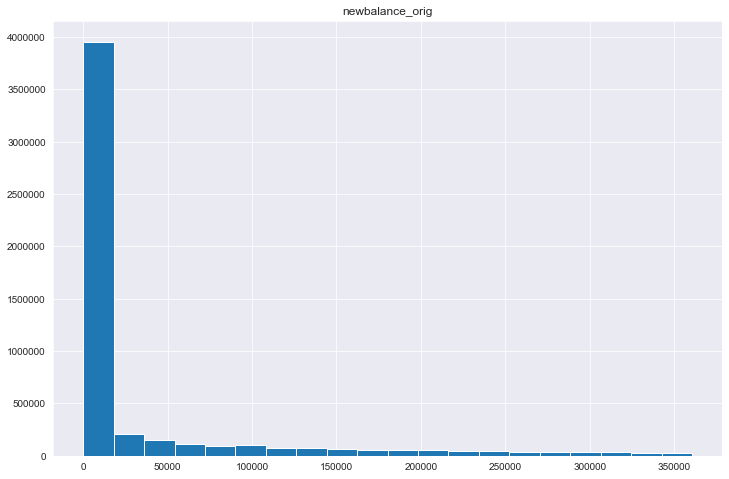

In [39]:
# Newbalance_orig
low, high = find_outliers(num_attributes,  'newbalance_orig')    
num_attributes[(num_attributes['newbalance_orig'] > low) & (num_attributes['newbalance_orig'] < high)].hist(column = 'newbalance_orig', bins = 20, figsize = (12,8))

Outliers limit for oldbalance_dest:
Q1 = 0.0
Q3 = 943036.7075
IQR = 943036.7075
low_outliers = -1414555.06125
high_outliers = 2357591.76875


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C38F7A908>]],
      dtype=object)

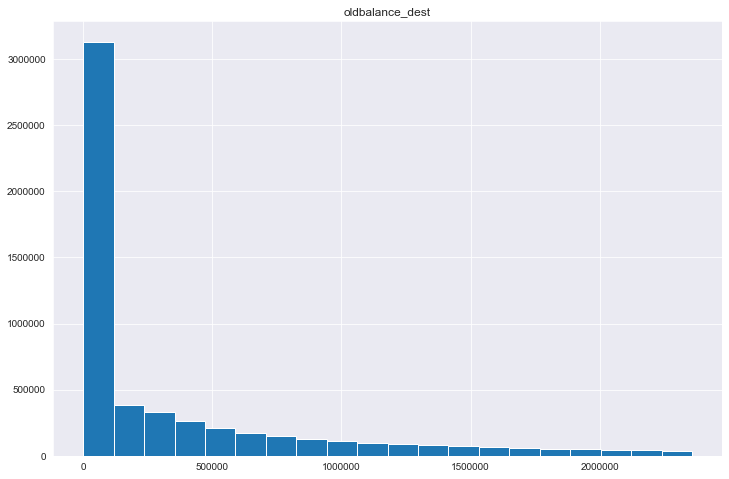

In [40]:
# Amount
low, high = find_outliers(num_attributes,  'oldbalance_dest')    
num_attributes[(num_attributes['oldbalance_dest'] > low) & (num_attributes['oldbalance_dest'] < high)].hist(column = 'oldbalance_dest', bins = 20, figsize = (12,8))

Outliers limit for newbalance_dest:
Q1 = 0.0
Q3 = 1111909.25
IQR = 1111909.25
low_outliers = -1667863.875
high_outliers = 2779773.125


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C391D0550>]],
      dtype=object)

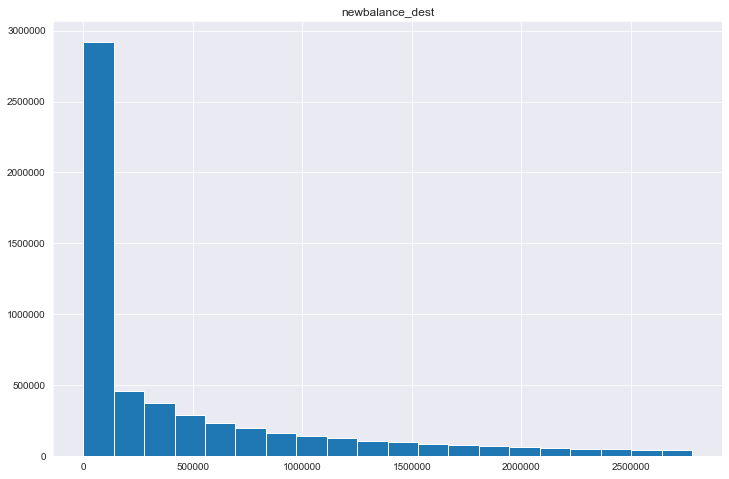

In [41]:
# Newbalance_dest
low, high = find_outliers(num_attributes,  'newbalance_dest')    
num_attributes[(num_attributes['newbalance_dest'] > low) & (num_attributes['newbalance_dest'] < high)].hist(column = 'newbalance_dest', bins = 20, figsize = (12,8))

Outliers limit for error_after_tran_orig:
Q1 = -114500.0925
Q3 = 0.0
IQR = 114500.0925
low_outliers = -286250.23124999995
high_outliers = 171750.13874999998


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C3F09C588>]],
      dtype=object)

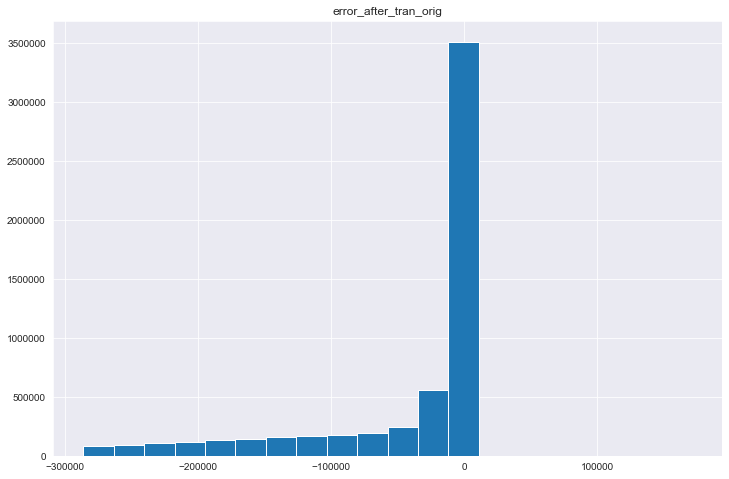

In [42]:
# Error_after_tran_orig
low, high = find_outliers(num_attributes,  'error_after_tran_orig')    
num_attributes[(num_attributes['error_after_tran_orig'] > low) & (num_attributes['error_after_tran_orig'] < high)].hist(column = 'error_after_tran_orig', bins = 20, figsize = (12,8))

Outliers limit for error_after_tran_dest:
Q1 = 0.0
Q3 = 0.0
IQR = 0.0
low_outliers = 0.0
high_outliers = 0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C3F0DC240>]],
      dtype=object)

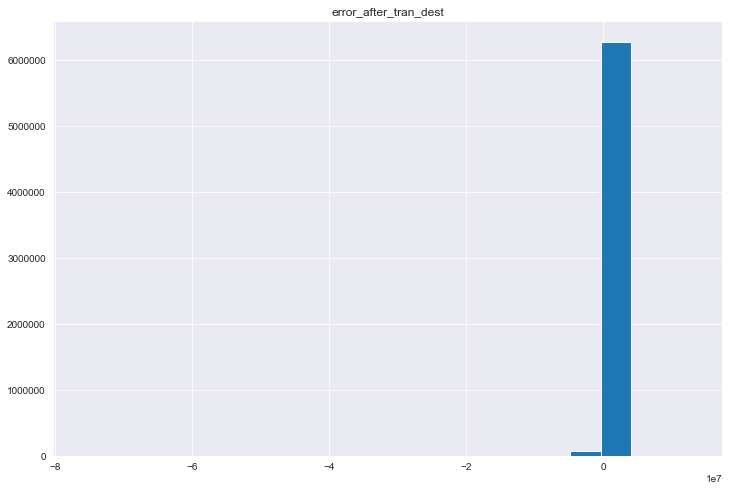

In [43]:
# Error_after_tran_dest
low, high = find_outliers(num_attributes,  'error_after_tran_dest')    
num_attributes.hist(column = 'error_after_tran_dest', bins = 20, figsize = (12,8))

In [44]:
df4['error_after_tran_dest'].value_counts(normalize=True).head()*100

 0.00    66.796163
 0.01     2.989743
-0.01     2.988879
 0.01     1.155232
-0.01     1.151695
Name: error_after_tran_dest, dtype: float64

In [45]:
df4['error_after_tran_orig'].value_counts(normalize=True).head()*100

 0.00    30.532485
-0.01     0.754501
 0.01     0.751844
 0.01     0.732513
-0.01     0.730014
Name: error_after_tran_orig, dtype: float64

**Summary of histogram analysis**:
- Most values are 0;
- Values follows a exponential distribution;
- The error after a transaction in destination smaller than in the origin.

#### 4.1.3 Categorical Attributes

In [46]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [47]:
cat_attributes['type'].value_counts(normalize = True)*100

CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: type, dtype: float64

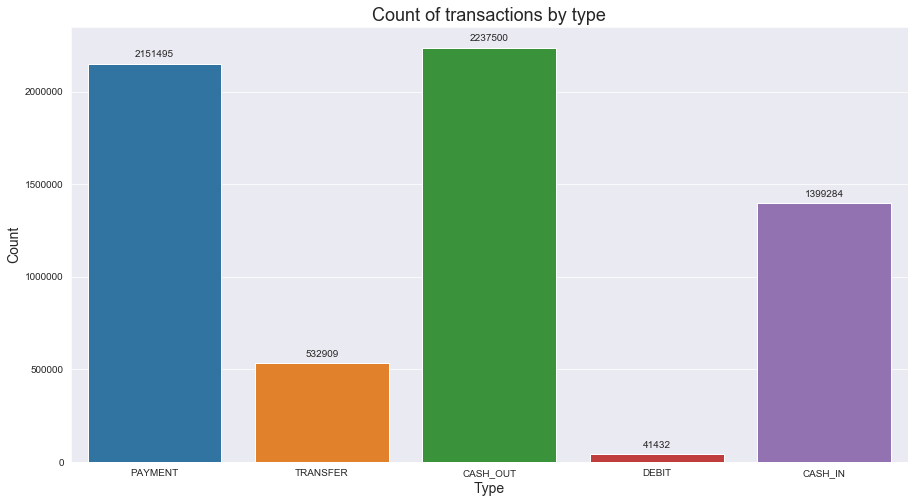

In [48]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'type', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by type', 'Type', 'Count')

- The most common types of transactions are CASH-OUT (35%) and PAYMENT (34%);

In [49]:
cat_attributes['client_origin'].value_counts(normalize = True)*100

Customer    100.0
Name: client_origin, dtype: float64

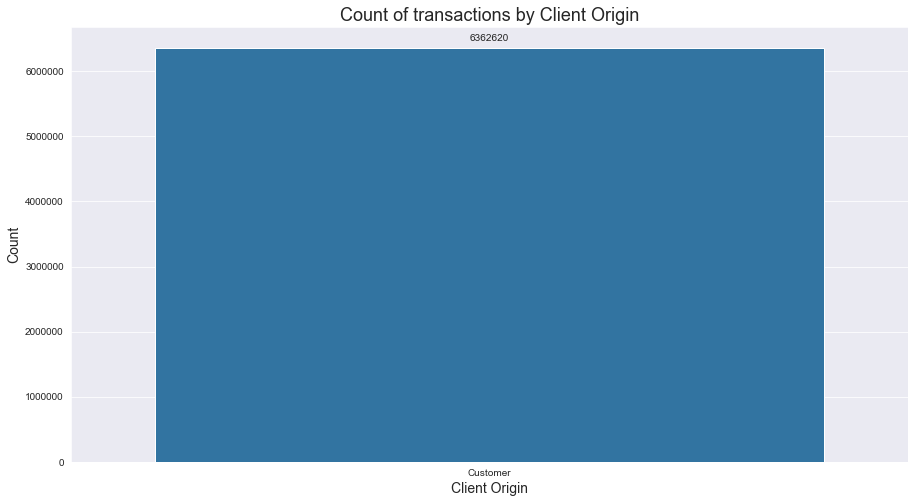

In [50]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'client_origin', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by Client Origin', 'Client Origin', 'Count')

- All the transactions from Origin side are done by Customers (100%).

In [51]:
cat_attributes['client_destination'].value_counts(normalize = True)*100

Customer    66.185392
Merchant    33.814608
Name: client_destination, dtype: float64

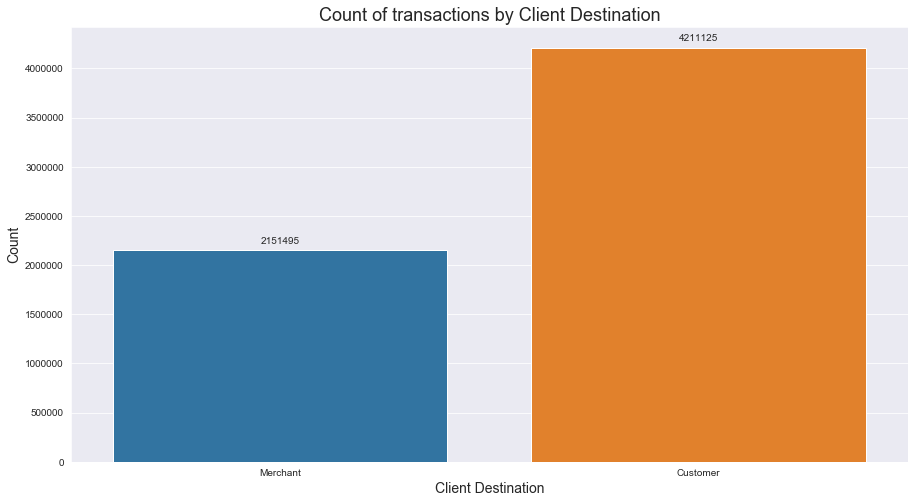

In [52]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'client_destination', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by Client Destination', 'Client Destination', 'Count')

- Analyzing  the Destination side, 66% of transactions are done from Customer to Customer and 34% from Customer to Merchant.

### 4.2 Bivariate Analysis

Bivariate Analysis will be used to validate all the hypothesis generated in the hypothesis list.

#### H1- Transactions classified as transfer is more likely to be fraud;
**FALSE**: Cash-Out and Transfer have almost the same number of fraud transactions, then it is not possible to affirm it.
However, when compared with regular transactions, transfer type is significantly greater than the regular ones (49.9% x 8.3%).

In [53]:
aux1 = df4[['type', 'is_fraud']].groupby('type').sum()
aux1.T

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
is_fraud,0,4116,0,0,4097


In [54]:
type_counts = (df4.groupby(['is_fraud'])['type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('type'))

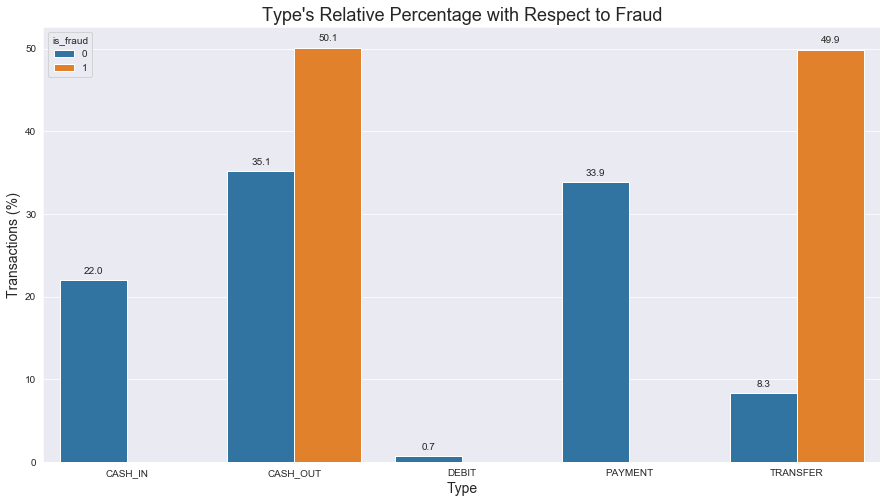

In [55]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x="type", y="percentage", hue="is_fraud", data=type_counts)
label_graph(ax, '.1f')
set_plots_features(ax, 'Type\'s Relative Percentage with Respect to Fraud', 'Type', 'Transactions (%)')

- Only Transfer and Cash-Out type transaction occur when a Fraud happen;
- Transfer and Cash-out have almost the same occurences of Fraud;
- When compared to relative percentage related to Fraud, Transfer is significantly greater than the regular transaction. Cash-out transaction is significanly greater too, but less than the the transfer comparison.

#### H2 - The average amount of money of fraudulent transactions classified as transfer is the highest value.
**TRUE**: The average amount of money by transaction is the highest value when a Fraud happen, followed by Cash-out with close values.

In [56]:
aux = df4.groupby(['is_fraud', 'type'])['amount'].mean().reset_index().sort_values('amount', ascending = False)
aux

,is_fraud,type,amount
6,1,TRANSFER,1.480892e+06
5,1,CASH_OUT,1.455103e+06
4,0,TRANSFER,9.062290e+05
1,0,CASH_OUT,1.739172e+05
0,0,CASH_IN,1.689202e+05
3,0,PAYMENT,1.305760e+04
2,0,DEBIT,5.483665e+03


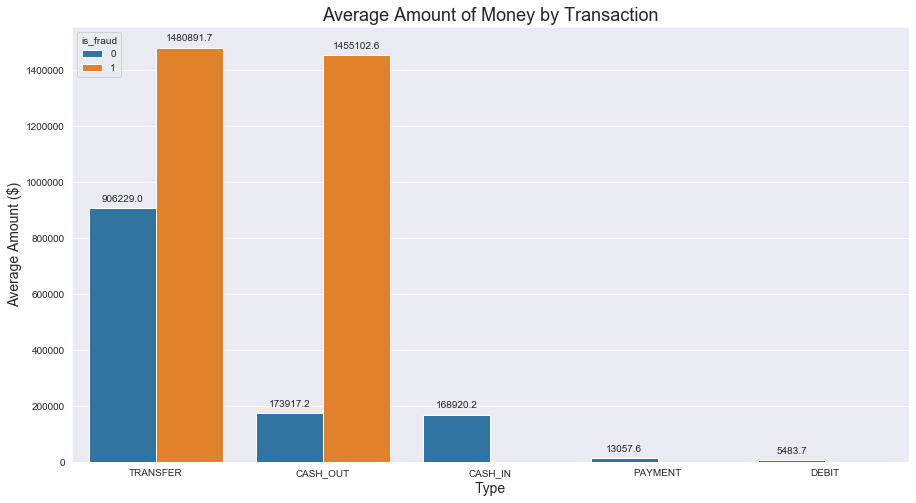

In [57]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'type', y = 'amount', hue = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Average Amount of Money by Transaction', 'Type', 'Average Amount ($)')



- The highest average amount of money related to fraud is from a Transfer transaction type;
- The difference of average amount of money is quite discrepant when a fraud occurs.

#### H3 - Customer-customer transactions tend to be more fraudulent than Customer-Merchant.



**TRUE**: There is no transaction Customer-Merchant which is classified as Fraud.

In [58]:
aux = df4[['client_destination', 'is_fraud']].groupby('client_destination')['is_fraud'].sum().reset_index()
aux

,client_destination,is_fraud
0,Customer,8213
1,Merchant,0


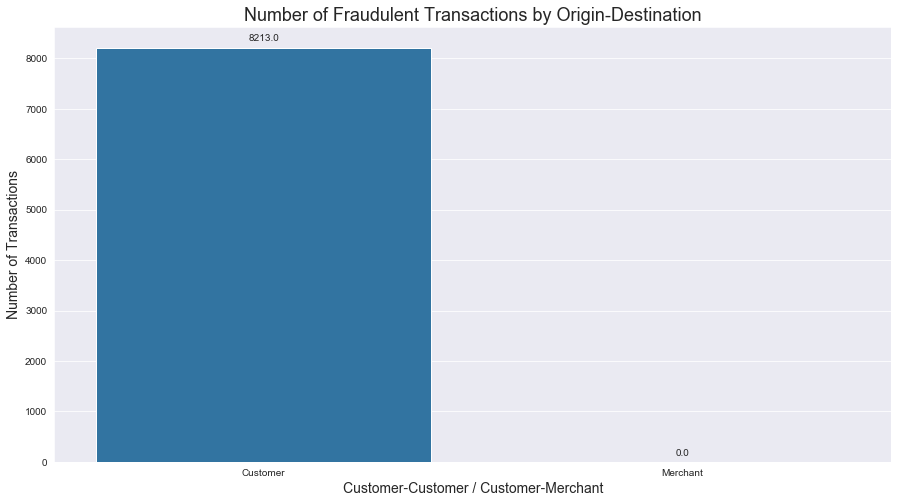

In [59]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'client_destination', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Origin-Destination', 'Customer-Customer / Customer-Merchant', 'Number of Transactions')



#### H4 - Transactions over \\$200.000,00 are always fraudulent.



**FALSE**: The number of fraudulent transactions is greater in transactions over $2000.000,00, but is not always.

In [65]:
aux = df4[['amount_group', 'is_fraud']].groupby('amount_group')['is_fraud'].sum().reset_index()
aux

,amount_group,is_fraud
0,0,1038
1,1,1704
2,2,5471


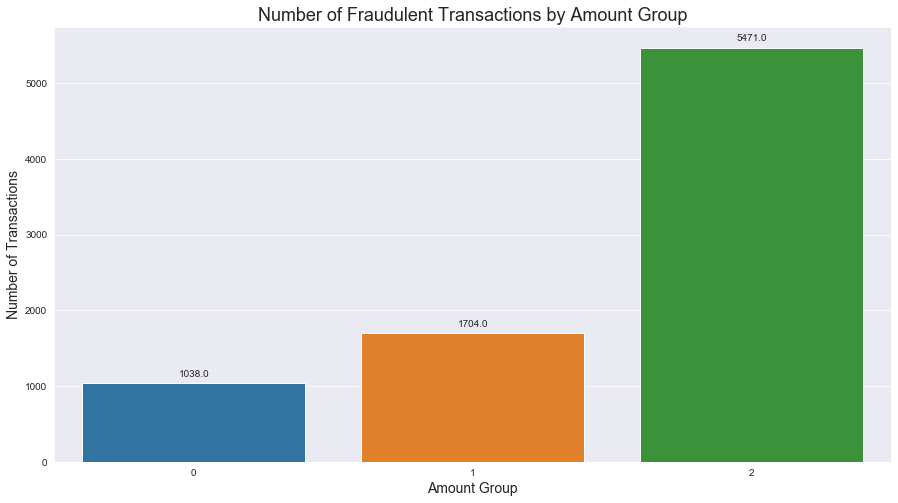

In [98]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'amount_group', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Amount Group', 'Amount Group', 'Number of Transactions')



#### H5 - Transactions before the 10th day of the month are more likely to be fraud.
**FALSE**: The number of transactions after 10th is greater than before. Also, the number of frauds per day is well balanced. 


In [302]:
aux = df4[['day', 'is_fraud']].groupby('day')['is_fraud'].sum().reset_index()

In [306]:
print('Number of fraudulent transactions before 10th:', aux[aux['day'] <= 10]['is_fraud'].sum())
print('Number of fraudulent transactions after 10th:', aux[aux['day'] > 10]['is_fraud'].sum())

Number of fraudulent transactions before 10th: 2987
Number of fraudulent transactions after 10th: 5226


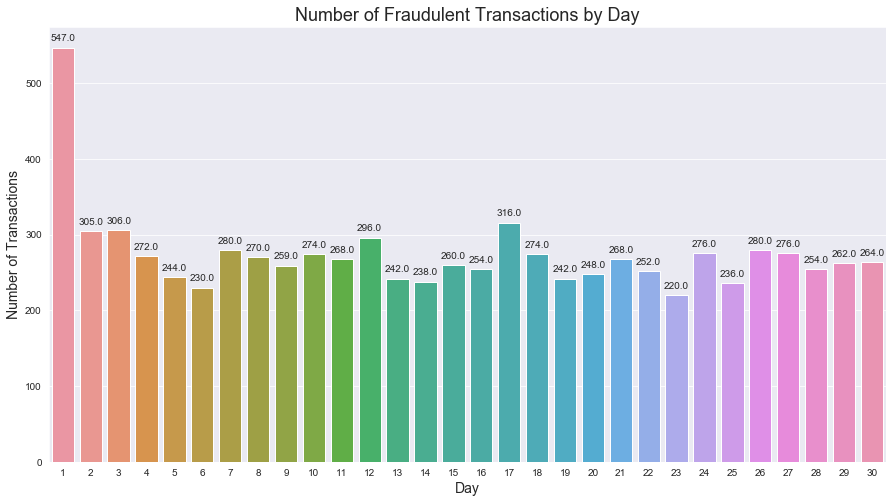

In [112]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'day', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Day', 'Day', 'Number of Transactions')

#### H6 - The first week of the month are more likely to be fraud.
**TRUE**: Despite the small difference, the first week is when more fraud happens.


In [122]:
aux = df4[['week', 'is_fraud']].groupby('week')['is_fraud'].sum().reset_index()

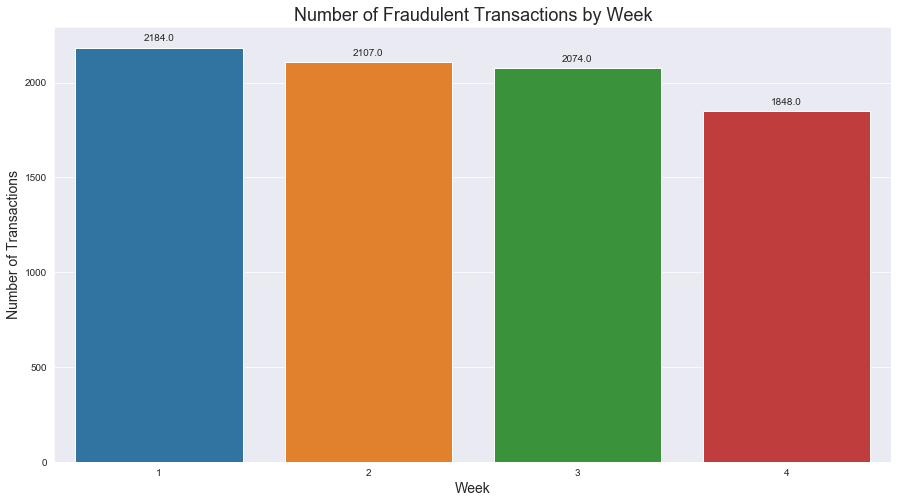

In [123]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'week', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Week', 'Week', 'Number of Transactions')

#### H7- Transactions during the work day are more likely to be fraud.
**FALSE**: Fraudulent transactions are more likely to happen during the days of work.


In [125]:
aux = df4[['day_of_week', 'is_fraud']].groupby('day_of_week')['is_fraud'].sum().reset_index()

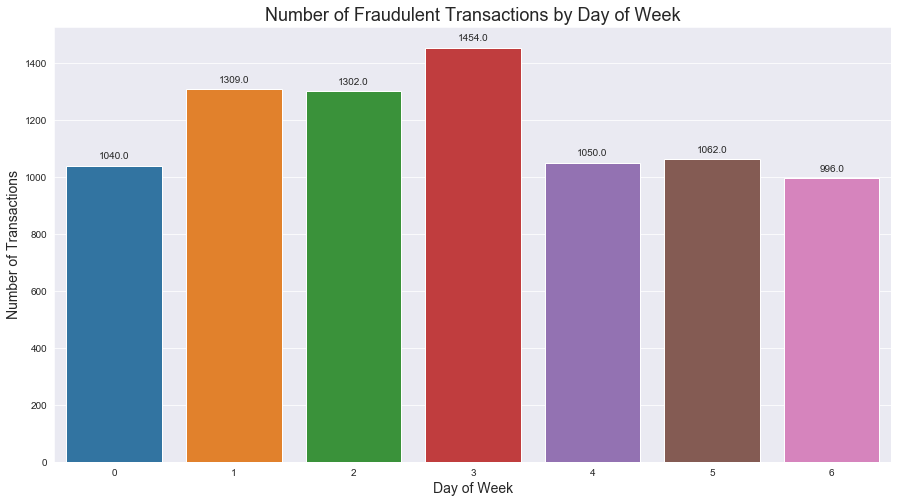

In [127]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'day_of_week', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Day of Week', 'Day of Week', 'Number of Transactions')

#### H8 - Transactions after 18h are more likely to be fraud.
**FALSE**: The number of fraudulent transactions during the day and the night is almost the same.


In [129]:
aux = df4[['hour', 'is_fraud']].groupby('hour')['is_fraud'].sum().reset_index()

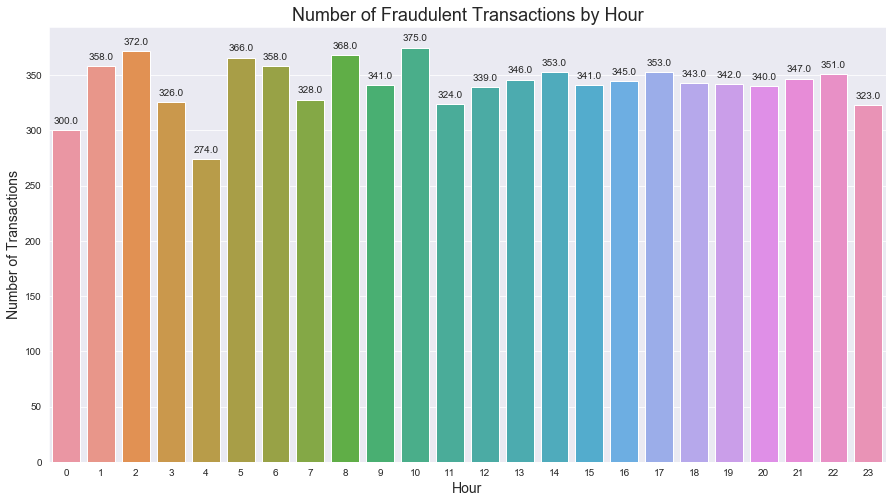

In [130]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'hour', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Hour', 'Hour', 'Number of Transactions')

#### H9 - When the origin new balance is equal zero and the old balance is greater than zero, it is more likely to be fraud;
**TRUE**: Almost always when a fraudulent transaction happen, the newbalance_orig is zero (98%). The percentage of transactions that have newbalance_orig equal zero when is a regular transaction is 35.6%, quite different than the fraudulent ones. 


In [180]:
aux = df4[df4['oldbalance_orig'] > 0]
aux2 = aux[aux['is_fraud'] == 1]
aux3 = aux2[['is_fraud', 'newbalance_orig']]['newbalance_orig'].value_counts(normalize = True)*100

In [183]:
aux4 = aux[aux['is_fraud'] == 0]
aux5 = aux4[['is_fraud', 'newbalance_orig']]['newbalance_orig'].value_counts(normalize = True)*100

In [197]:
aux6 = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux3.head()[0], aux5.head()[0]]})

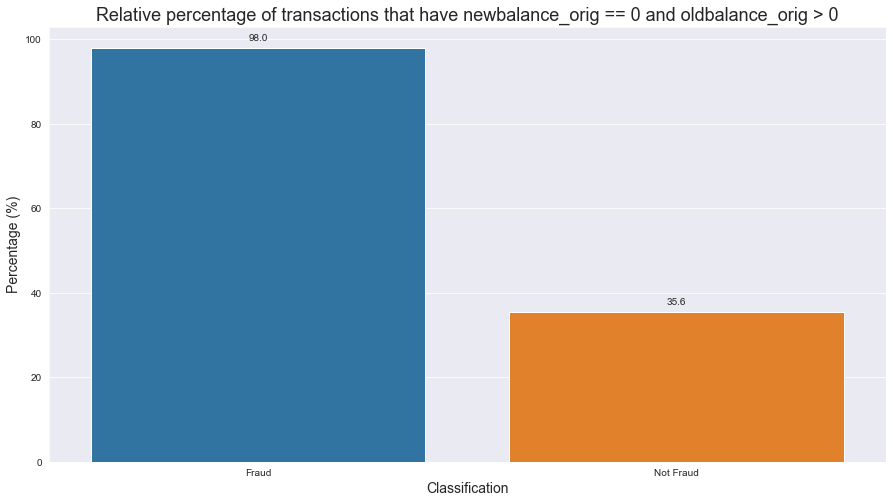

In [199]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_orig == 0 and oldbalance_orig > 0', 'Classification', 'Percentage (%)')

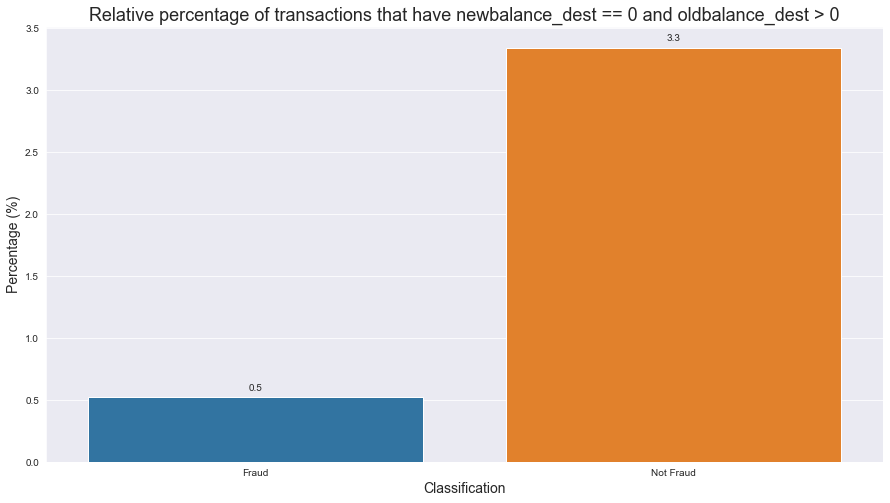

In [213]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_dest == 0 and oldbalance_dest > 0', 'Classification', 'Percentage (%)')

#### H10 - When the destination new balance is equal zero and the old balance is greater than zero, it is more likely to be fraud;

**FALSE**: The same pattern of origin account is not followed in the destination account, the relative percentage is very small in both classifications.

In [215]:
aux = df4[df4['oldbalance_dest'] > 0]
aux2 = aux[aux['is_fraud'] == 1]
aux3 = aux2[['is_fraud', 'newbalance_dest']]['newbalance_dest'].value_counts(normalize = True)*100

In [216]:
aux4 = aux[aux['is_fraud'] == 0]
aux5 = aux4[['is_fraud', 'newbalance_dest']]['newbalance_dest'].value_counts(normalize = True)*100

In [220]:
aux6 = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux3.head()[0], aux5.head()[0]]})

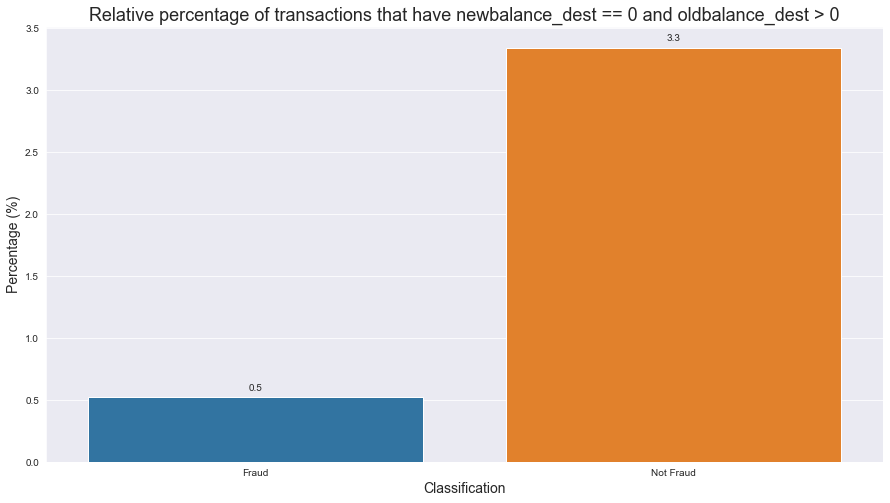

In [221]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_dest == 0 and oldbalance_dest > 0', 'Classification', 'Percentage (%)')

#### H11 - When the error before and after a transaction in the origin side is different than zero, a fraud occurs.
**FALSE**: Most fraudulent transactions have the error equal to zero.

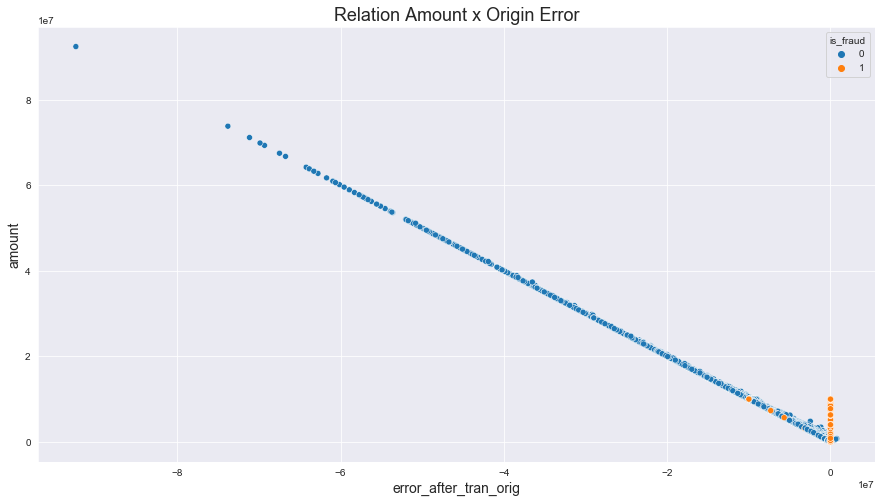

In [293]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_orig', y = 'amount', hue = 'is_fraud', data = df4)
set_plots_features(ax, 'Relation Amount x Origin Error', 'error_after_tran_orig', 'amount')

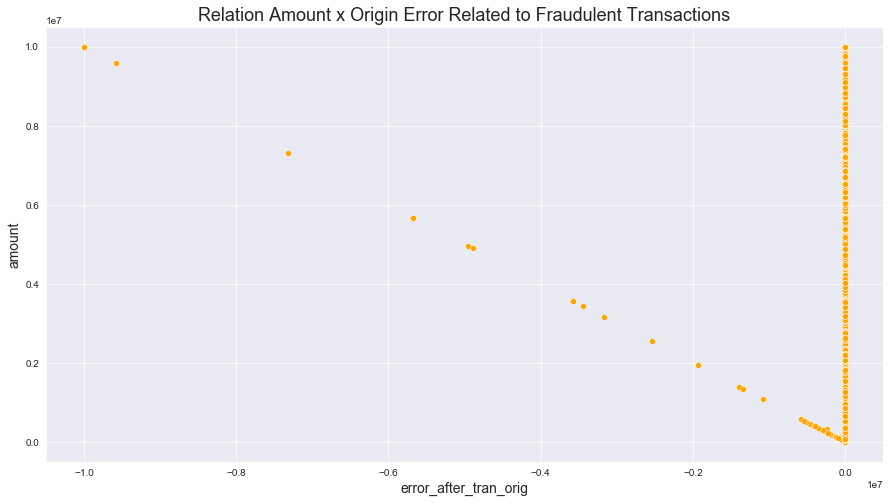

In [292]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_orig', y = 'amount', data = df4[df4['is_fraud'] == 1], color = 'orange')
set_plots_features(ax, 'Relation Amount x Origin Error Related to Fraudulent Transactions', 'error_after_tran_orig', 'amount')

In [249]:
aux = df4[['is_fraud', 'error_after_tran_orig', 'amount']].groupby(['is_fraud', 'error_after_tran_orig'])['amount'].count().reset_index()

In [257]:
aux_df_fraud = df4[df4['is_fraud'] == 1]
aux_df_nofraud = df4[df4['is_fraud'] == 0]

In [279]:
aux_fraud = aux[aux['is_fraud'] == 1]
aux_fraud['rel_perc'] = aux_fraud['amount'] / len(aux_df_fraud)
aux_nofraud = aux[aux['is_fraud'] == 0]
aux_nofraud['rel_perc'] = aux_nofraud['amount'] / len(aux_df_nofraud)

aux_fraud = aux_fraud.sort_values('amount', ascending = False).head()*100
aux_nofraud = aux_nofraud.sort_values('amount', ascending = False).head()*100

aux_comp = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux_fraud['rel_perc'].iloc[0], aux_nofraud['rel_perc'].iloc[0]]})

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


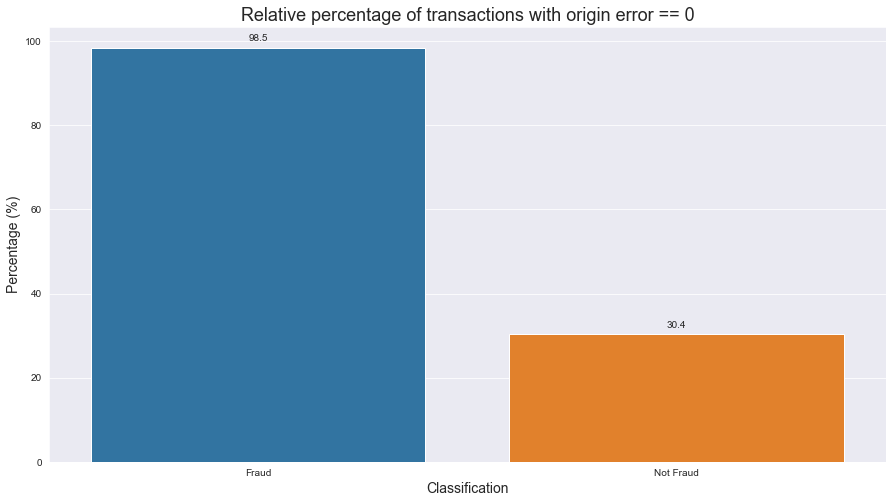

In [278]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux_comp)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions with origin error == 0', 'Classification', 'Percentage (%)')

- Most fraudulent transactions have an error in the origin account equal zero, while the regular ones shows a 45º slope (amount = difference)
- A negative value of error means that the transaction amount is not properly taken into account in the origin balance.
- The error in the origin side does not mean a fraudulent transaction, but I think this might be an insight to take into account and fix it quickly.
- Related to fraudulent transactions, 98.5% have the error equal to zero, while the regular transactions have 30.4%.

#### H12 - When the error before and after a transaction in the  destination side is different than zero, a fraud occurs.
**TRUE**: There is a strong pattern that shows fraudulent transactions with error different than zero.

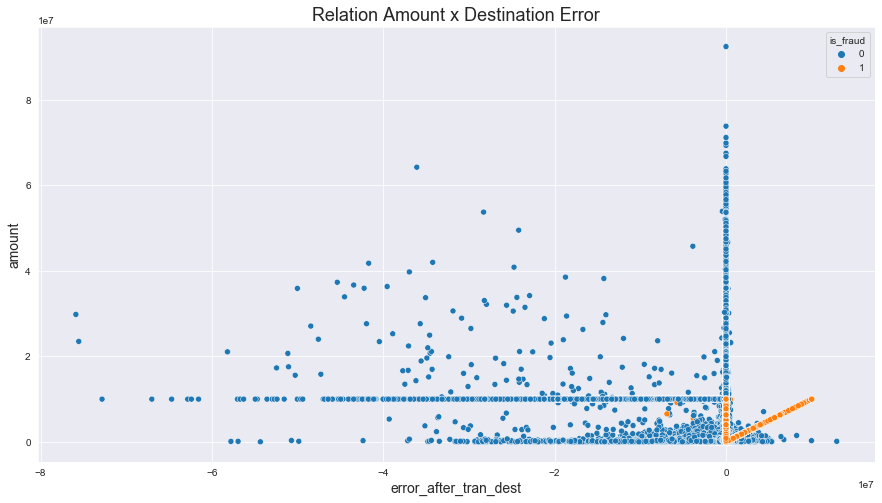

In [291]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_dest', y = 'amount', hue = 'is_fraud', data = df4)
set_plots_features(ax, 'Relation Amount x Destination Error', 'error_after_tran_dest', 'amount')

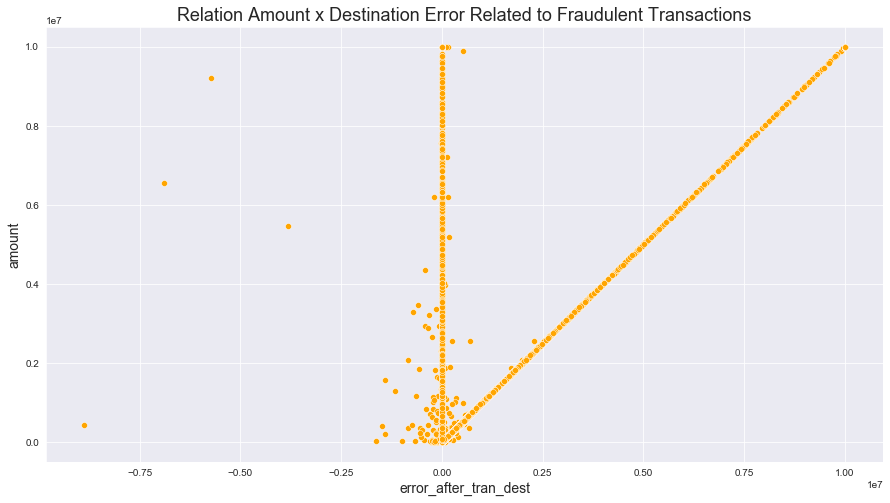

In [290]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_dest', y = 'amount', data = df4[df4['is_fraud'] == 1], color = 'orange')
set_plots_features(ax, 'Relation Amount x Destination Error Related to Fraudulent Transactions', 'error_after_tran_dest', 'amount')

In [280]:
aux = df4[['is_fraud', 'error_after_tran_dest', 'amount']].groupby(['is_fraud', 'error_after_tran_dest'])['amount'].count().reset_index()

In [281]:
aux_fraud = aux[aux['is_fraud'] == 1]
aux_fraud['rel_perc'] = aux_fraud['amount'] / len(aux_df_fraud)
aux_nofraud = aux[aux['is_fraud'] == 0]
aux_nofraud['rel_perc'] = aux_nofraud['amount'] / len(aux_df_nofraud)

aux_fraud = aux_fraud.sort_values('amount', ascending = False).head()*100
aux_nofraud = aux_nofraud.sort_values('amount', ascending = False).head()*100

aux_comp = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux_fraud['rel_perc'].iloc[0], aux_nofraud['rel_perc'].iloc[0]]})

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


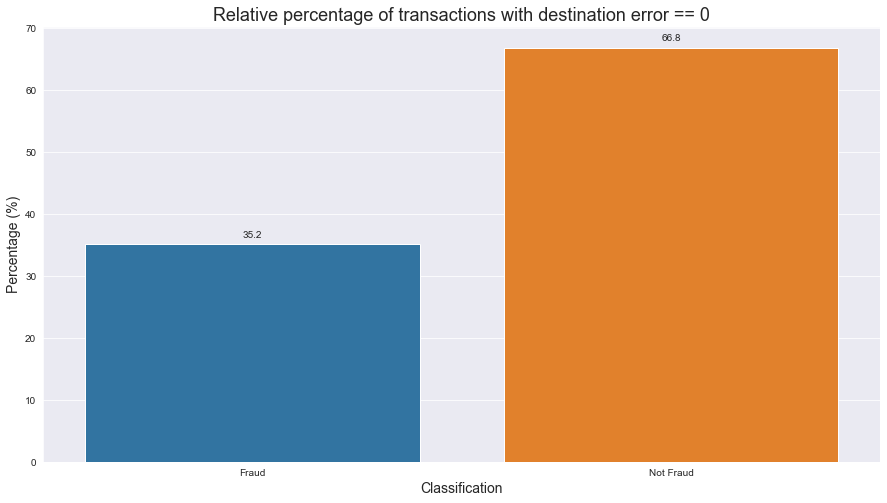

In [282]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux_comp)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions with destination error == 0', 'Classification', 'Percentage (%)')

- Fraudulent transactions have both patterns, when the error is equal 0 and equal to the amount of money.
- The scatterplot of fraudulent transactions shows when the error in destination account before and after a transaction is equal to the amount of money, a fraud occurs more likely (45º slope);
- Error = Amount means that the balance in destination account does not change after the transaction.
- Related to fraudulent transactions, only 35.2% have the error equal to zero, while the regular transactions have 66.8%.

### 4.3 Multivariate Analysis

In [294]:
# Separte the numerical and categorical attributes
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

#### 4.3.1 Numerical Attributes

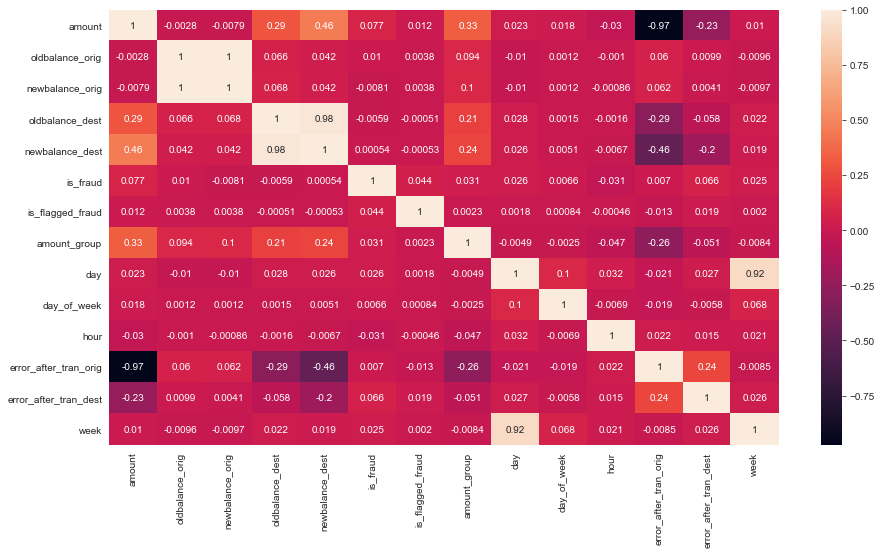

In [297]:
# Calculate the correlation matrix using the pearson method
corr_matrix = num_attributes.corr(method='pearson')

# Plot the heatmap
plt.figure(1, figsize=(15,8))
sns.heatmap(corr_matrix, annot = True)

- newbalance_orig x oldbalance_orig (1.0 - Indicates colinearity)
- oldbalance_dest x amount (0.29 - medium correlation)
- newbalance_dest x amount (0.46 - medium correlation)
- amount x amount_group (0.33 - medium correlation)
- error_after_tran_orig x amount (-0.97 - strong negative correlation)
- error_after_tran_dest x amount (-023 - medium correlation)
- newbalance_dest x oldbalance_dest (0.98 - strong positive correlation)
- amount_group x newbalance_dest (0.24 - medium correlation)
- error_after_tran_orig x newbalance_dest (-0.46 - medium correlation)
- error_after_tran_orig x amount_group (-0.26 - medium correlation)
- day x week (0.92 - strong positive correlation)
- error_after_tran_orig x error_after_tran_dest (0.24 - medium correlation)

**Observation**:
- Some variables are very strong correlated and that can indicate multicolinearity between the independent features;


#### 4.3.2 Categorical Attributes

The categoerical features does not have information with exception of type.

## 4.0 Data Preparation

## 5.0 Machine Learning Models

## 6.0 Performance